## Import the necessary modules from SymPy

In [1]:
from sympy import symbols, simplify, factor, expand, lambdify,Matrix, prod
import numpy as np
import math
import itertools
from pathlib import Path
import sympy
import matplotlib.pyplot as plt

# import msprime
import numpy as np
import pandas as pd

from itertools import combinations,permutations,combinations_with_replacement
from operator import  mul
from functools import  *

In [2]:
# Define the symbols used in the expression
# 'a', 'b', 'c', 'd' are general variables.
# 'e', 'eps' (epsilon), 'delta' are also variables, often representing small quantities or parameters.
a, b, c, d, e, f, t0,t1,t2,t3,t4,sigma, = symbols('a b c d e f t0 t1 t2 t3 t4 sigma')

taxa = [a, b, c, d, e, f,]
branching_times = [t0,t1,t2,t3,t4]
root_to_tip = sum(branching_times)

# Define the given mathematical expression
# The expression is broken down into three main terms for clarity,
# then summed together.

contrast = lambda a,b,e: (a-b)**2 / e


def f_full(a,b,c,d,e,f):
    c1 = contrast(a,b,2*t0)
    c2 = contrast(c, d, 2 * (t0+t1))
    c3 = contrast(e, f, 2 * (t0+t1+t2))
    x1 = ( a + b ) / 2
    x2 = (c + d) / 2
    x3 = (e + f) / 2
    bias_full = (t0/2 + t1 + t2 + t3)
    bias_cherries = ((t0+t1)/2 + t2 + t3)
    e3 = ((t0+t1+t2)/2 + t3 + t4)
    denom = bias_full + bias_cherries 
    c4 = contrast(x1, x2, denom)
    x4 = (bias_full*x2+bias_cherries*x1) / (bias_full+bias_cherries)
    e4 = (bias_full*bias_cherries) / (bias_full+bias_cherries)
    c5 = contrast(x3,x4, e3 + e4 + t4)
    return (c1+c2+c3+c4+c5) / 5


def enumerate_k_partitions(n, k):
    """
    Enumerates all unique ways to partition n distinct elements into sets of size k.

    This function works by recursively finding sets of k elements. It fixes the
    first available element and forms a set of k elements by combining it with
    k-1 other available elements, then recursively finds partitions for the
    remaining elements.

    Args:
        n (int): The total number of elements to partition. Elements are represented by
                 integers from 0 to n-1.
        k (int): The desired size of each set in the partition.

    Returns:
        list: A list of lists, where each inner list represents a unique partition.
              Each partition is a list of tuples, where each tuple is a set of k elements
              (e.g., (0, 1, 2)).
              Returns an empty list if k does not divide n, or if n, k are invalid.

    Raises:
        ValueError: If n is negative or k is not a positive integer.
    """
    if n < 0:
        raise ValueError("Number of elements (n) cannot be negative.")
    if k <= 0:
        raise ValueError("Set size (k) must be a positive integer.")
    if n % k != 0:
        # It's impossible to partition n elements into sets of size k if k does not divide n.
        # print(f"Warning: Cannot partition {n} elements into sets of size {k} because {k} does not divide {n}.")
        return []
    if n == 0:
        # Base case: There's one way to partition an empty set (an empty partition).
        return [[]]

    # Initialize the list of elements as integers from 0 to n-1
    elements = list(range(n))
    all_partitions = []

    # The core recursive function
    def _find_partitions(current_elements):
        # Base case: If no elements left, we found a valid partition.
        if not current_elements:
            return [[]]

        # Pick the first available element to start a new set
        first_element = current_elements[0]
        # Elements available for forming the rest of the current set
        remaining_to_choose_from = current_elements[1:]

        partitions_for_current_level = []

        # We need to choose k-1 additional elements to form a set of size k
        # from the remaining_to_choose_from.
        # This is where itertools.combinations becomes useful.
        for combo_of_k_minus_1 in itertools.combinations(
            remaining_to_choose_from, k - 1
        ):
            # Form the current set, ensuring elements are sorted for uniqueness
            current_set = tuple(sorted((first_element,) + combo_of_k_minus_1))

            # Create the list of elements remaining after forming this set
            # This involves removing 'first_element' and all elements in 'combo_of_k_minus_1'
            elements_in_current_set = set(current_set)  # Use a set for efficient lookup
            elements_after_set = [
                e for e in current_elements if e not in elements_in_current_set
            ]

            # Recursively find partitions for the remaining elements
            sub_partitions = _find_partitions(elements_after_set)

            # Combine the current set with all sub-partitions found
            for sub_p in sub_partitions:
                partitions_for_current_level.append([current_set] + sub_p)

        return partitions_for_current_level

    all_partitions = _find_partitions(elements)
    return all_partitions


def generate_moments(variables, cov, max_moment=None):
    n = len(variables)
    r = range(n)
    moments = []
    for k in range(1, max_moment or n + 1):
        m = {}
        for x in combinations_with_replacement(r, k):
            indices = enumerate_k_partitions(k, 2)
            m[reduce(mul, (variables[i] for i in x))] = sum(
                reduce(mul, (cov[x[i], x[j]] for i, j in ix)) for ix in indices
            )
        moments.append(m)
    return moments

Tree shape is $(((a,b):T1,(c,d):T2):T4,(e,f):T3):T5$.  Alternatively we could have (a,b) and (c,d) merge before e and f.

In [ ]:
cov = Matrix([
    [ root_to_tip,      root_to_tip-t0,     t4,             t4,           0,                  0],
    [root_to_tip-t0,    root_to_tip,        t4,             t4,           0,                  0],
    [t4,                t4,                 root_to_tip,    t2+t3+t4,     0,                  0],
    [t4,                t4,                 t2+t3+t4,       root_to_tip,  0,                  0],
    [0,                 0,                  0,             0,             root_to_tip,        t3+t4 ],
    [0,                 0,                  0,             0,             t3+t4,              root_to_tip ]
    ]) * sigma**2



In [ ]:
moments = generate_moments(taxa, cov)

cherry = expand(( contrast(a,b,2*t0) + 
                 contrast(c,d, 2*(t0+t1)) + 
                  contrast(e,f,2*(t0+t1+t2))) / 3)

pic = f_full(*taxa)


In [ ]:

pic_e = expand(pic)
for m in reversed(moments):
    pic_e = pic_e.subs(m)
simplify(pic_e)

In [ ]:
pic_v = expand(pic**2-sigma**4)
for m in reversed(moments):
    pic_v = pic_v.subs(m)
simplify(pic_v)

In [ ]:
from sympy import Matrix, print_latex
print_latex(pic_v)

### Three Taxa

In [7]:
def f_full(a,b,c): 
    c1 = contrast(a,b,2*t0)
    x1=(a+b) / 2
    v1 = (t0/2 + t1)
    v2 = (t0 + t1)
    denom = v1+v2 #[:,np.newaxis] 
    c2 = contrast(x1, c, denom)
    return (c1+c2) / 2

cov = Matrix([
        [t0 + t1,  t1,       0], 
        [t1,       t0 + t1,  0], 
        [0,        0,        t0 + t1],
                            ]) * sigma**2


variables = [a, b, c]
pic = simplify(f_full(a, b, c))

moments = list(reversed(generate_moments(variables, cov, cov.shape[1] + 2)))

def substitute_moments(expr):
    for m in moments:
        expr = expr.subs(m, simultaneous=True)
    return expr


In [9]:
pic

(t0*(a + b - 2*c)**2 + (a - b)**2*(3*t0 + 4*t1))/(4*t0*(3*t0 + 4*t1))

In [8]:

epic = simplify(substitute_moments(expand(pic)))
vpic = simplify(substitute_moments(expand((pic - epic) ** 2)))
vpic


sigma**4

In [5]:
vpic

sigma**4

In [6]:
cherry = contrast(a,b,2*t0)

epic_c = substitute_moments(expand(cherry))
vpic_c = substitute_moments(expand((cherry - epic_c) ** 2))

simplify(vpic_c)

2*sigma**4

In [ ]:
vpic_c.subs({t0:100,t1:10})
simplify(epic)

### three taxa, misspecified

In [ ]:

cov = Matrix([
        [t0 + t1, 0,        t1], 
        [0,       t0 + t1,  0], 
        [t1,        0,        t0 + t1],
                            ]) * sigma**2


variables = [a, b, c]
pic = f_full(a, b, c)

moments = list(reversed(generate_moments(variables, cov, cov.shape[1] + 2)))

def substitute_moments(expr):
    for m in moments:
        expr = expr.subs(m, simultaneous=True)
    return expr


epic = simplify(substitute_moments(expand(pic)))
vpic = simplify(substitute_moments(expand((pic - epic) ** 2)))
vpic


In [ ]:
vpic.subs({t0:1,t1:.01})

In [ ]:
vpic.subs({sigma:1, })


In [2]:

func = sympy.lambdify(
    (t0,t1),
    vpic.subs(sigma,1),
    modules='numpy'
)

x = np.linspace(0,1,100)
plt.plot(x,func(1,x));

NameError: name 'sympy' is not defined

In [ ]:

func = sympy.lambdify(
    (t0,t1),
    vpic.subs(sigma,1),
    modules='numpy'
)

x = np.linspace(0,1,100)
plt.plot(x,func(1,x));


## four taxa
$((a:t0, b:t0):t1, c:t0+t1):t2, d:t0+t1+t2)$

In [10]:
def f_full(a,b,c,d): 
    c1 = contrast(a,b,2*t0)
    x1=(a+b) / 2
    v1 = (t0/2 + t1)
    v2 = (t0 + t1)
    denom = v1+v2 #[:,np.newaxis] 
    c2 = contrast(x1, c, denom)
    x2 =( x1*v2 + c*v1 ) / denom 
    e_k = v2*v1 / denom 
    c3 = contrast(x2,d, 2*t2 + t1 + t1 + e_k)
    return (c1+c2+c3) / 3

variables = [a, b, c,d]
pic = f_full(a, b, c,d)

cov = Matrix([
        [t0 + t1+t2,  t1+t2,       t2, 0], 
        [t1+t2,       t0 + t1 +t2, t2, 0], 
        [t2,          t2,          t0 + t1+t2, 0],
        [0,           0,           0, t0 + t1+t2],
                            ]) * sigma**2

moments = list(reversed(generate_moments(variables, cov, cov.shape[1] + 2)))

def substitute_moments(expr):
    for m in moments:
        expr = expr.subs(m, simultaneous=True)
    return expr


In [4]:
moments

[{a**5: 0,
  a**4*b: 0,
  a**4*c: 0,
  a**4*d: 0,
  a**3*b**2: 0,
  a**3*b*c: 0,
  a**3*b*d: 0,
  a**3*c**2: 0,
  a**3*c*d: 0,
  a**3*d**2: 0,
  a**2*b**3: 0,
  a**2*b**2*c: 0,
  a**2*b**2*d: 0,
  a**2*b*c**2: 0,
  a**2*b*c*d: 0,
  a**2*b*d**2: 0,
  a**2*c**3: 0,
  a**2*c**2*d: 0,
  a**2*c*d**2: 0,
  a**2*d**3: 0,
  a*b**4: 0,
  a*b**3*c: 0,
  a*b**3*d: 0,
  a*b**2*c**2: 0,
  a*b**2*c*d: 0,
  a*b**2*d**2: 0,
  a*b*c**3: 0,
  a*b*c**2*d: 0,
  a*b*c*d**2: 0,
  a*b*d**3: 0,
  a*c**4: 0,
  a*c**3*d: 0,
  a*c**2*d**2: 0,
  a*c*d**3: 0,
  a*d**4: 0,
  b**5: 0,
  b**4*c: 0,
  b**4*d: 0,
  b**3*c**2: 0,
  b**3*c*d: 0,
  b**3*d**2: 0,
  b**2*c**3: 0,
  b**2*c**2*d: 0,
  b**2*c*d**2: 0,
  b**2*d**3: 0,
  b*c**4: 0,
  b*c**3*d: 0,
  b*c**2*d**2: 0,
  b*c*d**3: 0,
  b*d**4: 0,
  c**5: 0,
  c**4*d: 0,
  c**3*d**2: 0,
  c**2*d**3: 0,
  c*d**4: 0,
  d**5: 0},
 {a**4: 3*sigma**4*(t0 + t1 + t2)**2,
  a**3*b: 3*sigma**4*(t1 + t2)*(t0 + t1 + t2),
  a**3*c: 3*sigma**4*t2*(t0 + t1 + t2),
  a**3*d: 0,
  a**

In [ ]:

epic = substitute_moments(expand(pic))
vpic = substitute_moments(expand((pic - epic) ** 2))
vpic


In [ ]:
epic

In [ ]:
vpic = substitute_moments(expand((pic - epic) ** 2))
vpic


## simulate balanced 6

In [6]:

def f_full(a, b, c, d, e, f):
    c1 = contrast(a, b, 2 * t0)
    c2 = contrast(c, d, 2 * (t0 + t1))
    c3 = contrast(e, f, 2 * (t0 + t1 + t2))
    x1 = (a + b) / 2
    x2 = (c + d) / 2
    x3 = (e + f) / 2
    bias_full = t0 / 2 + t1 + t2 + t3
    bias_cherries = (t0 + t1) / 2 + t2 + t3
    e3 = (t0 + t1 + t2) / 2 + t3 + t4
    denom = bias_full + bias_cherries
    c4 = contrast(x1, x2, denom)
    x4 = (bias_full * x2 + bias_cherries * x1) / (bias_full + bias_cherries)
    e4 = (bias_full * bias_cherries) / (bias_full + bias_cherries)
    c5 = contrast(x3, x4, e3 + e4 + t4)
    return (c1 + c2 + c3 + c4 + c5) / 5

def f_cherries(a,b,c,d,e,f):
    return (contrast(a,b,2*t0)+contrast(c,d,2*(t0+t1))+contrast(e,f,2*(t0+t1+t2))) / 3

In [11]:
from scipy import stats

x0=0
mu = np.repeat(x0,6)

t0 = 1
n_trees=2000
mse_full,mse_cherries,m3,bias_full,bias_cherries,sigs,var_full,var_cherries,v3=([] for _ in range(9))
for _ in range(n_trees):
    
    [sigsq, t1, t2, t3, t4] = np.random.rand(5)
    k = .001
    t1,t2,t3,t4 = t1/k,t2/k,t3/k,t4/k
    root_to_tip = sum([t0, t1, t2, t3, t4])
    cov = (
        Matrix(
            [
                [root_to_tip, root_to_tip - t0, t4, t4, 0, 0],
                [root_to_tip - t0, root_to_tip, t4, t4, 0, 0],
                [t4, t4, root_to_tip, t2 + t3 + t4, 0, 0],
                [t4, t4, t2 + t3 + t4, root_to_tip, 0, 0],
                [0, 0, 0, 0, root_to_tip, t3 + t4],
                [0, 0, 0, 0, t3 + t4, root_to_tip],
            ]
        )
        * sigsq
    )
    sigs.append(sigsq)
    values = stats.multivariate_normal(mu, cov, allow_singular=True).rvs(20_000).T
    s_hat_1 = f_full(*values)
    s_hat_2 = f_cherries(*values)
    mse_full.append(((s_hat_1-sigsq)**2).mean())
    mse_cherries.append(((s_hat_2-sigsq)**2).mean())
    s_hat_1_mean = s_hat_1.mean()
    s_hat_2_mean = s_hat_2.mean()
    bias_full.append(s_hat_1_mean-sigsq)
    bias_cherries.append(s_hat_2_mean-sigsq)
    var_full.append(mse_full[-1] - bias_full[-1]**2)
    var_cherries.append(mse_cherries[-1] - bias_cherries[-1]**2) # (s_hat_2**2).mean() - s_hat_2_mean**2
  

In [12]:
res = pd.DataFrame({
    'bias_full':bias_full, 
    'bias_cherries':bias_cherries, 
    'var_full':var_full, 
    'var_cherries':var_cherries, 
    'sigs':sigs
})

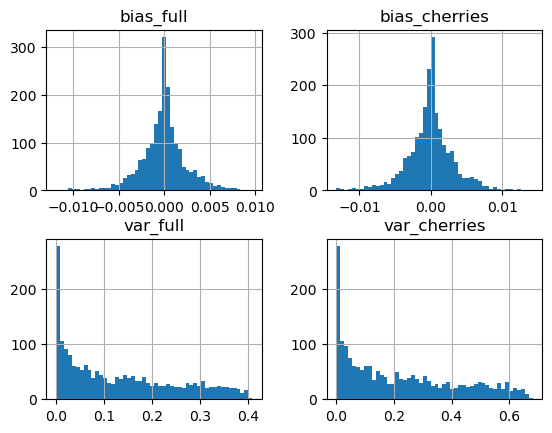

In [13]:
res.drop(columns='sigs').hist(bins=50);

In [16]:
# res.bias_full /= res.sigs
# res.bias_cherries /= res.sigs
res.var_full /= res.sigs**2
res.var_cherries /= res.sigs**2

# (r=.drop(columns='sigs').div(res.sigs, axis=0))

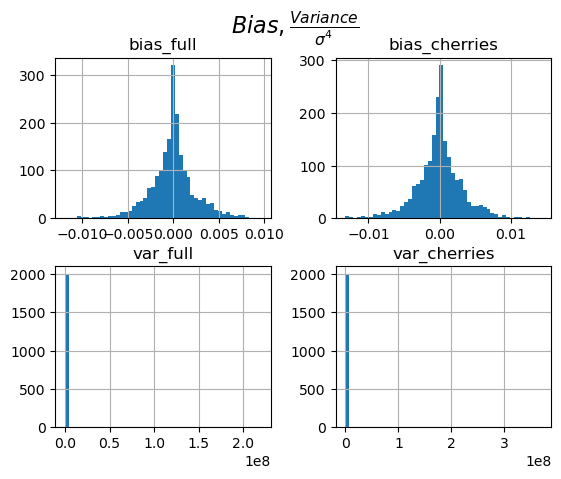

In [17]:
# fig = plt.figure();
res.drop(columns='sigs').hist(bins=50);
plt.gcf().suptitle(r'$Bias, \frac{Variance}{\sigma^4}$', fontsize=16);
# fig.tight_layout()

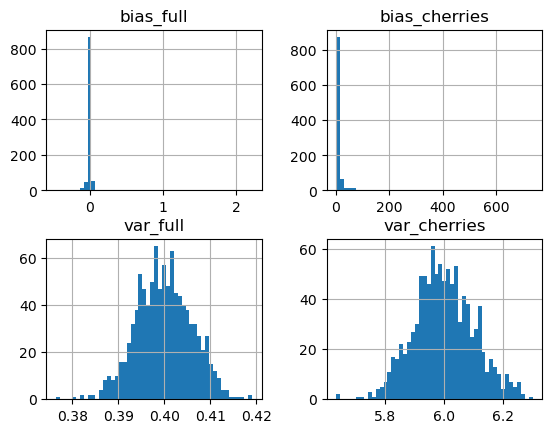

In [16]:
(res.drop(columns='sigs').div(res.sigs**2, axis=0)).hist(bins=50);

### 7 taxa

In [ ]:

def f_full(a, b, c, d, e, f, g):
    c1 = contrast(a, b, 2 * t0)
    c2 = contrast(c, d, 2 * (t0 + t1))
    c3 = contrast(e, f, 2 * (t0 + t1 + t2))
    x1 = (a + b) / 2
    x2 = (c + d) / 2
    x3 = (e + f) / 2
    bias_full = t0 / 2 + t1 + t2 + t3
    bias_cherries = (t0 + t1) / 2 + t2 + t3
    e3 = (t0 + t1 + t2) / 2 + t3 + t4
    denom = bias_full + bias_cherries
    c4 = contrast(x1, x2, denom)
    x4 = (bias_full * x2 + bias_cherries * x1) / (bias_full + bias_cherries)
    e4 = (bias_full * bias_cherries) / (bias_full + bias_cherries)
    c5 = contrast(x3, x4, e3 + e4 + t4)
    x5 = 
    c6 = contrast()
    return (c1 + c2 + c3 + c4 + c5) / 6

def f_cherries(a,b,c,d,e,f,g):
    return (contrast(a,b,2*t0)+contrast(c,d,2*(t0+t1))+contrast(e,f,2*(t0+t1+t2))) / 3

## Simulate New

In [102]:
parent_dir =Path('/home/b/rate_timescaling/data/tree_sims/l7.5/m6.750/h5/no_ils')
trees = parent_dir / 'sigmas_species_tree.npz'

In [4]:
!ls /home/b/rate_timescaling/data/tree_sims/l7.5/m6.750/h5/no_ils

EB_estimates_ngenes1_r20.RData		   pic_js_sigmas20_ngenes1_full.npy
delta_estimates_ngenes1_r20.RData	   pic_js_sigmas20_ngenes1_full_v2.npy
pic_bbridge_sigmas20_ngenes1_cherries.npy  pic_js_sigmas20_ngenes1_paired.npy
pic_bbridge_sigmas20_ngenes1_full.npy	   samples_ngenes1.npz
pic_bbridge_sigmas20_ngenes1_paired.npy    sigmas_species_tree.npz
pic_js_sigmas20_ngenes1_cherries.npy	   taus.npy


In [5]:
sig = np.load(parent_dir /'pic_bbridge_sigmas20_ngenes1_full.npy')

In [6]:
np.where(sig[:,0] > 4)

(array([ 7,  8, 30, 32, 48, 55, 58, 63, 64, 66, 79, 80, 85, 97]),)

In [7]:
preds = pd.read_csv('/home/b/rate_timescaling/data/pic_predictions_no_ils.csv.gz')

In [8]:
with open('/home/b/rate_timescaling/data/tree_sims/l7.5/m6.750/h5/parent_trees_4plus.phy') as f:
    for i, line in enumerate( f):
        if i==7:
            break
            

In [9]:
from bd_functions import *

In [34]:
(preds.query('lam==7.5 & mu==6.75 & h==5').sigma).unique()#>3).mean()

459020    2.877876
459021    2.877876
459022    2.877876
459023    2.877876
459024    2.877876
            ...   
460975    4.359871
460976    4.359871
460977    4.359871
460978    4.359871
460979    4.359871
Name: sigma, Length: 1960, dtype: float64

In [ ]:
preds.query('lam==7.5 & mu==6.75 & h==5 & np.abs(sigma-3.34475274)<1e-3')

In [35]:
preds.iloc[460978]

lam               7.500000
mu                6.750000
h                 5.000000
bl_max            2.274422
bl_mean           0.235663
bl_median         0.100344
bl_min            0.000064
bl_q1             0.031813
bl_q3             0.270134
bl_std            0.335000
n               459.000000
rho              -0.408062
sigma             4.359871
sigma_cherry      1.108772
sigma_js          0.989410
sigma_js_old      1.020530
sigma_paired      1.114884
tau               0.108379
Name: 460978, dtype: float64

In [11]:
parent_tree = dendropy.Tree.get_from_string(line, "newick")
sigma = phylogenetic_covariance(parent_tree)

In [68]:
from scipy.stats import multivariate_normal
nsamps=1000
nleaves = len(sigma)
samples = multivariate_normal.rvs(np.zeros(nleaves), sigma, nsamps, i)

In [69]:
samples

array([[ 3.30176225, -1.17402474,  2.17343354, ..., -1.70355647,
        -0.95570332,  0.04492795],
       [ 2.64836262, -0.93966088,  3.02784422, ..., -0.29125265,
        -0.50028321, -0.72458665],
       [ 1.0697886 ,  0.02543653,  0.58697819, ...,  0.39322808,
         0.62370667,  0.19099257],
       ...,
       [-4.11719252, -0.24894368, -2.6362332 , ...,  0.97677143,
         0.84169431, -1.32080002],
       [ 2.19208274,  2.8776626 ,  2.19697419, ...,  1.93958161,
         2.57631996,  1.62714989],
       [ 4.70071079, -0.89176727,  3.54487559, ..., -1.08264859,
        -1.62304099, -2.73658998]], shape=(1000, 260))

In [89]:
sigmas = np.empty((3, nsamps,1))

from simulation.calculate_sigmas import *

for i,s in enumerate(samples):
    pic = PIC(
        t=parent_tree,
        chars=s[np.newaxis,:],
        calculate_pic=BrownianBridgePIC,
        max_replicates=1,
    )
    
    res = np.vstack(
        (
            pic.estimate_sigmas(),
            pic.cherries_sigma(),
            pic.paired_lineages_sigma(),
        )
    )
    sigmas[:, i] = res
sigmas = pd.DataFrame(sigmas.squeeze().T,columns=['full','cherry','pair'])


In [100]:
sigmas

,full,cherry,pair
0,1.545050,0.890680,0.886263
1,2.037824,0.949616,1.018498
2,1.732959,1.230181,1.164069
3,2.092985,1.235026,1.151426
4,1.947936,0.978899,1.142012
...,...,...,...
995,4.472601,0.826464,0.874304
996,3.217339,1.140973,1.144586
997,1.764652,0.987968,0.994871
998,3.130958,0.800231,0.901641


In [99]:
sigmasj = np.empty((3, nsamps,1))

from simulation.calculate_sigmas import *

for i,s in enumerate(samples):
    pic = PIC(
        t=parent_tree,
        chars=s[np.newaxis,:],
        calculate_pic=JamesSteinPIC,
        max_replicates=1,
    )
    
    res = np.vstack(
        (
            pic.estimate_sigmas(),
            pic.cherries_sigma(),
            pic.paired_lineages_sigma(),
        )
    )
    sigmasj[:, i] = res
    
sigmasj = pd.DataFrame(sigmasj.squeeze().T,columns=['full','cherry','pair'])


In [103]:
sigmasj.to_csv(parent_dir/'samps_tree0+7_js.csv.gz')
# sigmas['js'] = sigmasj.full
sigmas.to_csv(parent_dir /'samps_tree0+7.csv.gz')

In [140]:
!pwd

/home/b/rate_timescaling


,full,cherry,pair,js
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.965837,0.986519,0.988930,0.954782
std,1.934060,0.151467,0.123109,0.088026
min,0.907349,0.549644,0.662293,0.659547
25%,1.739133,0.879110,0.909265,0.894674
50%,2.350197,0.978714,0.982629,0.950949
75%,3.494616,1.087879,1.069971,1.008292
max,16.738372,1.499826,1.409428,1.267156


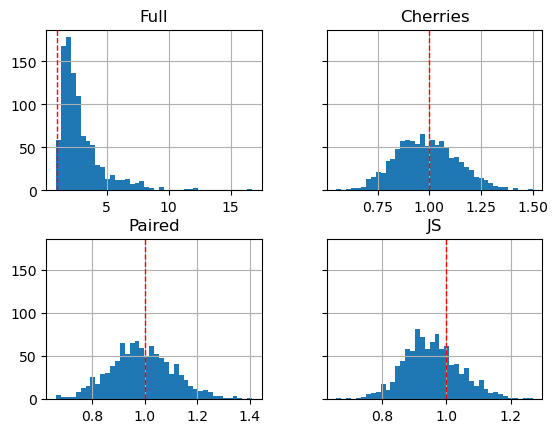

In [141]:

axes = sigmas.rename(columns={'full':'Full','cherry':'Cherries','pair':'Paired','js':'JS'}).hist(bins=40,sharey=True) #density=True
for ax in axes.ravel():
    ax.axvline(x=1,color='r',linestyle='dashed',linewidth=1)
plt.savefig('/home/b/rate_timescaling/figures/t0+7.png')
sigmas.describe()

array([<Axes: title={'center': 'Full'}>,
       <Axes: title={'center': 'Cherries'}>,
       <Axes: title={'center': 'Paired'}>, <Axes: title={'center': 'JS'}>],
      dtype=object)

,full,cherry,pair
count,1000.000000,1000.000000,1000.000000
mean,0.954782,0.986519,0.988930
std,0.088026,0.151467,0.123109
min,0.659547,0.549644,0.662293
25%,0.894674,0.879110,0.909265
50%,0.950949,0.978714,0.982629
75%,1.008292,1.087879,1.069971
max,1.267156,1.499826,1.409428


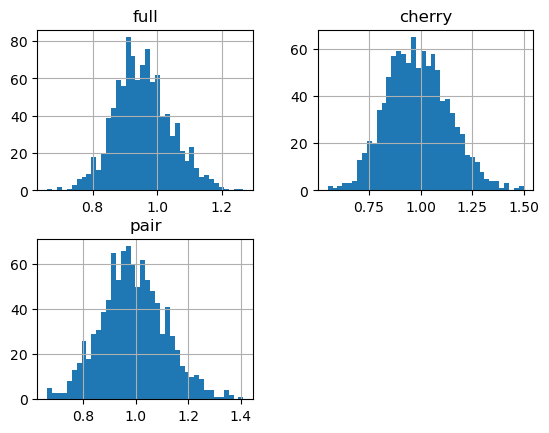

In [105]:
sigmasj.hist(bins=40)
sigmasj.describe()

In [77]:
from ete3 import Tree, NodeStyle, TreeStyle
t = Tree( line[5:] )
t.show()

QStandardPaths: wrong permissions on runtime directory /run/user/1000/, 0755 instead of 0700


In [108]:
sigmas['js']=sigmasj.full

In [ ]:
for d in sigmas:
    statistic, p_value = stats.shapiro(sigmas[d])
    print(d,statistic,p_value)

In [116]:
for d in sigmas:
    statistic, p_value = stats.shapiro(sigmas[d])
    print(d,statistic,p_value)

full 0.7602365366342545 9.160031736541993e-36
cherry 0.9965582172804532 0.02747046452660926
pair 0.9965317953463028 0.026294444687537766
js 0.9953573897796616 0.0039011976924582643


np.float64(0.33204633204633205)

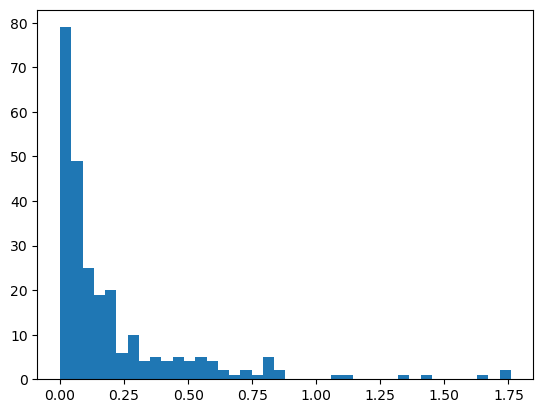

In [127]:
edges = np.array([e.length for e in parent_tree.internal_edges()])

plt.hist(
    edges,
    bins=40)

np.mean(edges<.05)

In [81]:
.151467**2

0.022942252088999998

In [83]:
255**-.5

0.06262242910851495

In [109]:
sigmas

,full,cherry,pair,js
0,1.545050,0.890680,0.886263,0.909154
1,2.037824,0.949616,1.018498,0.986201
2,1.732959,1.230181,1.164069,1.024381
3,2.092985,1.235026,1.151426,1.029463
4,1.947936,0.978899,1.142012,1.068081
...,...,...,...,...
995,4.472601,0.826464,0.874304,0.947188
996,3.217339,1.140973,1.144586,1.072113
997,1.764652,0.987968,0.994871,1.018295
998,3.130958,0.800231,0.901641,0.914626
